<a href="https://colab.research.google.com/github/entruv/NeuralChess/blob/master/Copy_of_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.layers import *
from keras.optimizers import Adam
from keras.models import Model
import numpy as np
import os
from PIL import Image
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
cd drive/My Drive/data/buildings

/content/drive/My Drive/data/buildings


In [17]:
X, y = np.load("X_train.npy")[0:70,238:-238,238:-238] / 255, np.load("y_train.npy")[0:70,238:-238,238:-238]
print(X.shape, y.shape)
y = y[:,:,:,0:1]
print(X.shape, y.shape)
y[y>0] = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

(70, 1024, 1024, 3) (70, 1024, 1024, 1)
(70, 1024, 1024, 3) (70, 1024, 1024, 1)


In [0]:
def unet(pretrained_weights = None,input_size = (256,256,3),start_filters=64):
    inputs = Input(input_size)
    conv1 = Conv2D(start_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(start_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(start_filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(start_filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(start_filters*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(start_filters*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(start_filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(start_filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(start_filters*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(start_filters*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(start_filters*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(start_filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(start_filters*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(start_filters*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(start_filters*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(start_filters*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(start_filters*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(start_filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(start_filters*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(start_filters, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(start_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(start_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(start_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = "Adam", loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [10]:
from keras.models import load_model
if 1:
  try:
    model = load_model("unet.h5")
    print("Loading existing model...")
  except:
    print("new model !")
    model = unet(input_size=(None, None, 3))

new model !
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, None, None, 6 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, None, None, 6 36928       conv2d_25[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, None, None, 6 0           conv2d_26[0][0]                  
_________________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [0]:
def crops(image, divide=10):
    #Crop the image in small image, "data augmentation"
    #image.shape=3024,4032,3
    result = []
    for i in [(image.shape[0] // divide) * i for i in np.arange(divide)]:
        for j in [(image.shape[1] // divide) * i for i in np.arange(divide)]:
            crop = image[i:i + image.shape[0] // divide, j:j + image.shape[1] // divide]
            result.append(crop)
    result = np.stack(result)
    return result

def crops_ds(X, y, divide=10):
    #Do cropping for all dataset, and managing also the y labels
    X_crops = []
    y_crops = []
    for i, image in enumerate(X):
        X_crops.append(crops(image, divide))
        y_crops.append(crops(y[i], divide))
    X_crops = np.stack(X_crops)
    y_crops = np.stack(y_crops)
    X_crops = X_crops.reshape(X_crops.shape[0] * X_crops.shape[1], X_crops.shape[2], X_crops.shape[3], X_crops.shape[4])
    y_crops = y_crops.reshape(y_crops.shape[0] * y_crops.shape[1], y_crops.shape[2],y_crops.shape[3], y_crops.shape[4])
    print(X_crops.shape, y_crops.shape)
    return X_crops, y_crops




In [0]:
def my_generator(bs=1):
    batch_X = []
    batch_y = []
    
    count = 0
    indices = np.arange(len(X_train_crops))
    np.random.shuffle(indices)
    while 1:
        for i in indices:
            if count == bs:
                yield np.stack(batch_X), np.stack(batch_y)
                count = 0
                
            batch_X.append(X_train_crops[i])
            batch_y.append(y_train_crops[i])
            count += 1

In [0]:
from keras.callbacks import TensorBoard, ModelCheckpoint
tb = TensorBoard("logs/unet")
cp = ModelCheckpoint("unet.h5", save_best_only=False)

In [0]:
#model.fit(X_train_crops, y_train_crops, validation_data=[X_test_crops, y_test_crops], batch_size=1, epochs=200, callbacks=[tb, cp])

In [0]:
#model = unet(input_size=(None, None, 3), start_filters=32)

In [19]:
X_train, y_train = crops_ds(X_train, y_train, divide=8)
X_test, y_test = crops_ds(X_test, y_test, divide=8)

(4032, 128, 128, 3) (4032, 128, 128, 1)
(448, 128, 128, 3) (448, 128, 128, 1)


In [21]:
model = unet(input_size=(None, None, 3), start_filters=32)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, None, None, 3 896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, None, None, 3 9248        conv2d_49[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, None, None, 3 0           conv2d_50[0][0]                  
__________________________________________________________________________________________________
conv2d_51 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [28]:
model.fit(X_train, y_train, validation_data=[X_test, y_test], batch_size=32, epochs=200, callbacks=[tb,cp])

Train on 4032 samples, validate on 448 samples
Epoch 1/200
4032/4032 [==============================] - 60s 15ms/step - loss: 0.1189 - acc: 0.9522 - val_loss: 0.1046 - val_acc: 0.9600
Epoch 2/200
4032/4032 [==============================] - 60s 15ms/step - loss: 0.1165 - acc: 0.9530 - val_loss: 0.1157 - val_acc: 0.9566
Epoch 3/200
4032/4032 [==============================] - 60s 15ms/step - loss: 0.1152 - acc: 0.9535 - val_loss: 0.1192 - val_acc: 0.9552
Epoch 4/200
4032/4032 [==============================] - 59s 15ms/step - loss: 0.1121 - acc: 0.9547 - val_loss: 0.1077 - val_acc: 0.9614
Epoch 5/200
4032/4032 [==============================] - 60s 15ms/step - loss: 0.1239 - acc: 0.9506 - val_loss: 0.1090 - val_acc: 0.9589
Epoch 6/200
4032/4032 [==============================] - 59s 15ms/step - loss: 0.1254 - acc: 0.9497 - val_loss: 0.1119 - val_acc: 0.9575
Epoch 7/200
4032/4032 [==============================] - 60s 15ms/step - loss: 0.1209 - acc: 0.9514 - val_loss: 0.1015 - val_acc: 0

KeyboardInterrupt: ignored

In [0]:
## To do 

## To do
1. Add npy files from different sources
2. Create generator who is changing the resolution of the image in input
3. Add Rotations / Brightness / Contraste changes

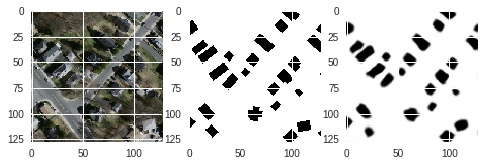

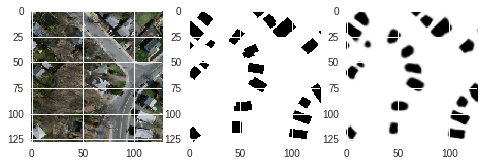

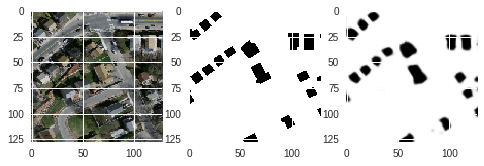

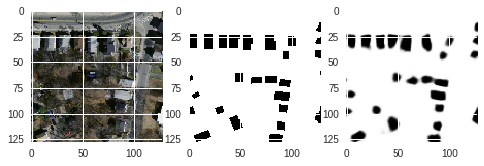

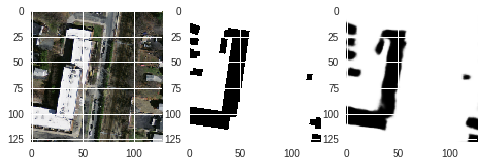

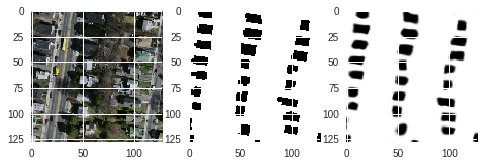

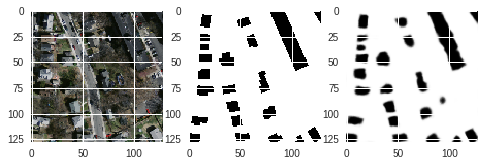

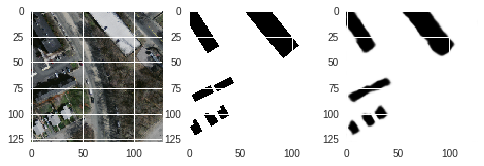

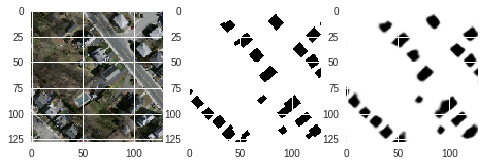

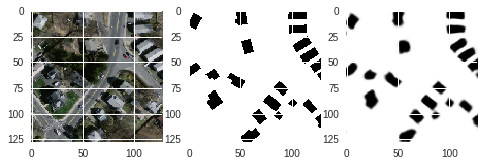

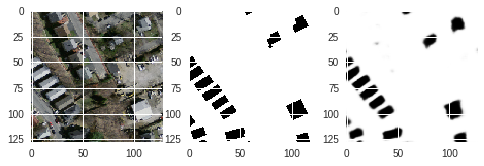

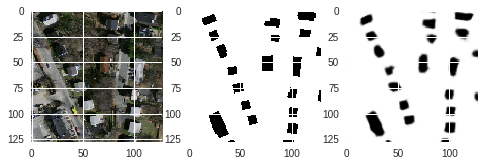

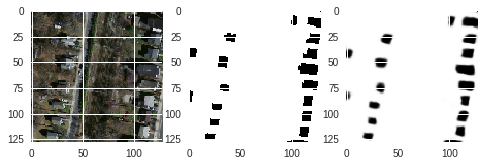

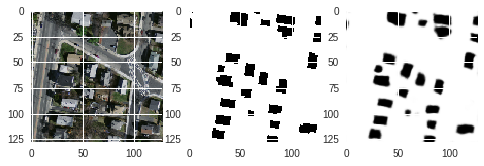

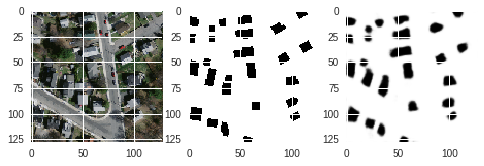

In [29]:
for i in range(15):
  fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=False)
  axs[0].imshow(X_train[i])
  axs[1].imshow(y_train[i,:,:,0])
  
  prediction = model.predict(X_train[i:i+1])
  axs[2].imshow(prediction[0,:,:,0])

In [0]:
prediction.max()

0.36601818